In [ ]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

import umap
import umap.plot


import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(context='notebook', style='white', rc={'figure.figsize':(11,11)})

In [ ]:
sys.path.append('../gan-vae-pretrained-pytorch')

#### GAN

In [4]:
# load the models
from mnist_dcgan.dcgan import Discriminator, Generator

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# load weights
D.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_dcgan/weights/netD_epoch_99.pth'))
G.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_dcgan/weights/netG_epoch_99.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()


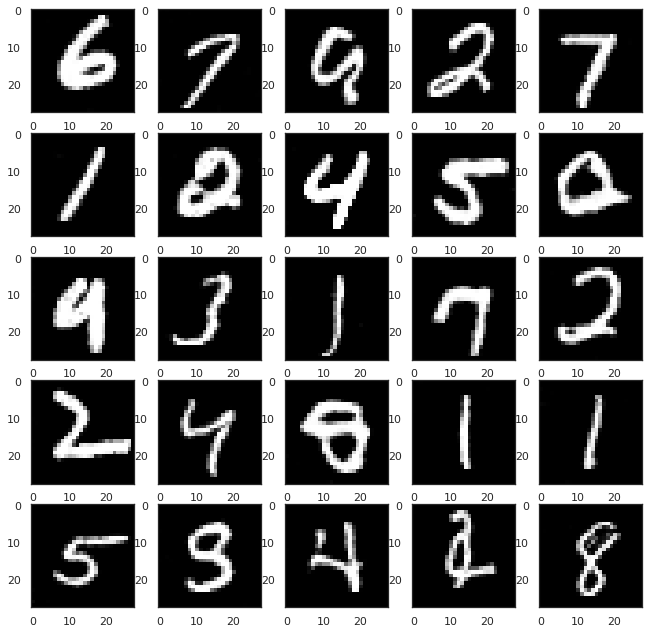

In [5]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()


In [6]:
outputs = D(fake_images)
print(outputs)
print(outputs.mean())

tensor([2.3489e-01, 2.6064e-01, 1.6973e-01, 3.8106e-02, 1.0352e-01, 1.6151e-01,
        4.0731e-02, 8.2403e-02, 8.4857e-01, 1.5324e-04, 5.3165e-01, 1.3527e-01,
        4.0220e-01, 6.6411e-01, 6.7878e-02, 1.9980e-02, 9.5567e-02, 5.6235e-01,
        2.6217e-01, 3.0282e-01, 3.1402e-01, 1.2527e-01, 3.0089e-01, 9.3169e-02,
        1.2549e-02], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.2332, device='cuda:0', grad_fn=<MeanBackward0>)


#### Classifier

In [7]:
from mnist_classifier.lenet import LeNet5
from torchvision.datasets.mnist import MNIST

classifier = LeNet5().eval()
classifier.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth'))
if torch.cuda.is_available():
    classifier = classifier.cuda()

#### Dataset

In [8]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

data_root = '~/mnist'
data_test = MNIST(data_root,
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize(28),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,), (0.5,))]))
data_loader = torch.utils.data.DataLoader(data_test, 
                                          batch_size=10000,
                                          shuffle=False)
(ims, labs) = next(iter(data_loader)) # get whole dataset
if torch.cuda.is_available():
    ims = ims.cuda()
labs = labs.numpy()

In [9]:
ims.shape

torch.Size([10000, 1, 28, 28])

#### Other GAN

In [302]:
fashion_model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=True)
fashion_model.avgG.to('cuda')
for param in fashion_model.avgG.parameters():
    param.requires_grad = True

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [36]:
num_images = 64
fasion_noise, _ = fashion_model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = fashion_model.test(fasion_noise)
    # change range to [0, 1] and set channels to RGB
    generated_images = generated_images.permute(0, 2, 3, 1)*0.5+0.5

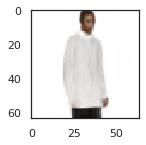

In [200]:
plt.figure(figsize = (2, 2))
plt.imshow(generated_images[8])

In [220]:
# fasion_noise[2]

In [ ]:
white_mask = red.mean(-1) < WHITE_THRESH
white_mask.shape

In [71]:
WHITE_THRESH = 0.999
red = generated_images[3]
red[white_mask].mean(0)

tensor([0.6701, 0.4695, 0.4289])

In [90]:
colors_list = []
for i in range(len(generated_images)):
    white_mask = generated_images[i].mean(-1) < WHITE_THRESH
    colors_list.append(generated_images[i][white_mask].mean(0))
colors = torch.stack(colors_list)

In [153]:
colors_norm = colors/colors.mean(-1, keepdim=True)
COLOR_THRESH = 1.2
RED, GREEN, BLUE = 0, 1, 2
RED_THRESH = 1.2
GREEN_THRESH = 1.0
BLUE_THRESH = 1.0

In [170]:
torch.where(colors_norm[:,RED] > RED_THRESH)

(tensor([ 3, 46, 61]),)

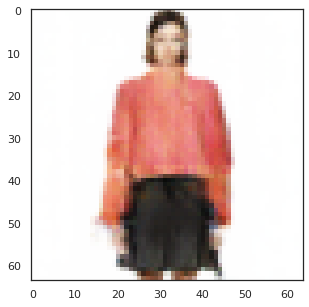

In [171]:
plt.figure(figsize = (5, 5))
plt.imshow(generated_images[3])

In [160]:
colors_norm[33]

tensor([0.9133, 0.9943, 1.0924])

In [481]:
RED, GREEN, BLUE = 0, 1, 2
WHITE_THRESH = 0.999
RED_THRESH = 1.4
GREEN_THRESH = 1.4#1.1
BLUE_THRESH = 1.4#1.0

def get_fashion_colors(generated_images):
    colors_list = []
    for i in range(len(generated_images)):
        white_mask = generated_images[i].mean(-1) < WHITE_THRESH
        colors_list.append(generated_images[i][white_mask].mean(0))
    colors = torch.stack(colors_list)
    return colors

def red_loss(generated_images):    
    colors = get_fashion_colors(generated_images)
    colors_norm = colors/colors.mean(-1, keepdim=True)
    
    # error is for all images with RED below threshold
    error = torch.clamp(RED_THRESH - colors_norm[:,RED], 0, None)**2
    loss = error.mean()
    return loss

def green_loss(generated_images):    
    colors = get_fashion_colors(generated_images)
    colors_norm = colors/colors.mean(-1, keepdim=True)
    
    # error is for all images with RED below threshold
    error = torch.clamp(GREEN_THRESH - colors_norm[:,GREEN], 0, None)**2
    loss = error.mean()
    return loss

def blue_loss(generated_images):    
    colors = get_fashion_colors(generated_images)
    colors_norm = colors/colors.mean(-1, keepdim=True)
    
    # error is for all images with RED below threshold
    error = torch.clamp(BLUE_THRESH - colors_norm[:,BLUE], 0, None)**2
    loss = error.mean()
    return loss

def white_loss(generated_images, thresh=0.5):
    colors = get_fashion_colors(generated_images)
    whiteness = colors.mean(-1)
    
    # error is for all images with whiteness below threshold
    error = torch.clamp(thresh - whiteness, 0, None)**2
    loss = error.mean()
    return loss

def black_loss(generated_images, thresh=0.5):
    colors = get_fashion_colors(generated_images)
    blackness = 1-colors.mean(-1)
    
    # error is for all images with whiteness below threshold
    error = torch.clamp(thresh-blackness, 0, None)**2
    loss = error.mean()
    return loss


In [202]:
red_loss(generated_images)

tensor(0.1494)

In [206]:
colors = get_fashion_colors(generated_images)
colors_norm = colors/colors.mean(-1, keepdim=True)
red_images = generated_images[colors_norm[:,RED] > RED_THRESH]

In [482]:
def fashion_model_fn(x):
    return fashion_model.test(x, getAvG=True, toCPU=False)

def train_fashion(perturb, class_weight=1, perturb_weight=1, disc_weight=1, iters=300, 
          save_dir=None, feature_extractor=None, mapping=None, real_embeds=None, conditional=False):
    
    if not (save_dir is None and mapping is None and real_embeds is None and feature_extractor is None):
        if not (save_dir is not None and mapping is not None and real_embeds is not None and feature_extractor is not None):
            print("dawg give it to me straight")
            return
    
    
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    optimizer = torch.optim.Adam(perturb.parameters())
    
    class_loss_fn = nn.CrossEntropyLoss()
    perturb_loss_fn = nn.MSELoss()
    disc_loss_fn = nn.BCELoss()
    
    # noise for visualiztion
    vis_noise = gen_noise(25)

    losses = []
    for i in range(iters):

        # Train one iteration
        optimizer.zero_grad()
        
        num_images = 1024
        fashion_noise, _ = fashion_model.buildNoiseData(num_images)
#         generated_images = fashion_model.test(fashion_noise)
        # change range to [0, 1] and set channels to RGB
#         generated_images = generated_images.permute(0, 2, 3, 1)*0.5+0.5
        
#         target = torch.ones(batch_size).long().cuda()

        
        noise_p, images, _, _ = gen_images(fashion_noise, model=fashion_model_fn, disc=None, classifier=None, perturb=perturb)
        # change range to [0, 1] and set channels to RGB
        images = images.permute(0, 2, 3, 1)*0.5+0.5
         
        class_loss = green_loss(images)# + 0.5*white_loss(images, thresh=0.3)
#         class_loss = black_loss(images, thresh=0.8)
        perturb_loss = perturb_loss_fn(noise_p, fashion_noise)
        
        loss = class_weight * class_loss + perturb_weight * perturb_loss

        loss.backward()
        optimizer.step()
        
        # Visualization
        
        if save_dir is not None and i % 3 == 0:
            with torch.no_grad():
                
                _, images, _, _ = gen_images(gen_noise(3072), perturb)
                image_feats = feature_extractor.get_feats(images).cpu().numpy()
                new_embeds = mapping.transform(image_feats)
                
                _, images, _, _ = gen_images(vis_noise, perturb)
                fig = plot_two_types(real_embeds, new_embeds, images.detach().cpu().numpy())
                
                filename = os.path.join(save_dir, 'frame'+str(i)+'.png')
                fig.savefig(filename, dpi=72)
                plt.close(fig)

        losses.append(loss.item())
        if i % 50 == 0:
            print('Iter', i, '-- Loss', loss.item())
            
    return losses


Iter 0 -- Loss 0.1696338653564453


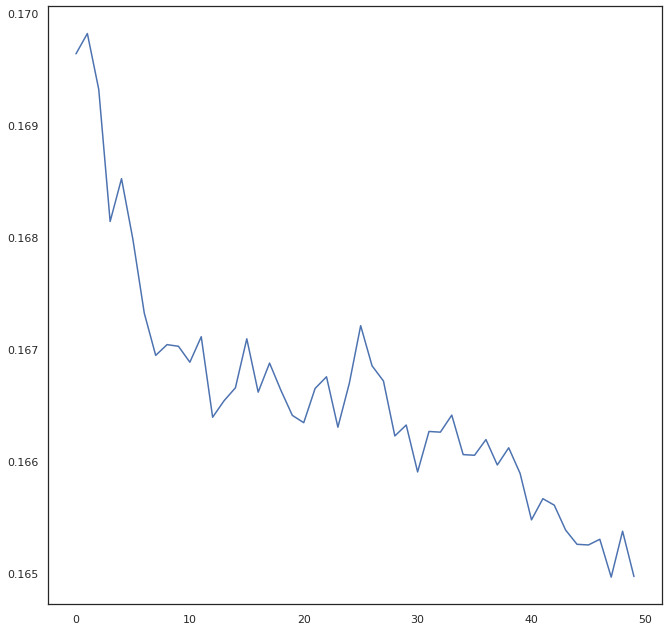

In [483]:
perturb_green_14 = get_perturb_network(latent_size=120, num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train_fashion(perturb_green_14, class_weight=1, perturb_weight=0.5, iters=50)
plt.plot(losses)

In [487]:
num_images = 16
fashion_noise, _ = fashion_model.buildNoiseData(num_images)

image_combo = []
# for perturb in [None, perturb_white_07, perturb_white_08, perturb_white_09, perturb_white]:
# for perturb in [None, perturb_white_09, perturb_black_08, perturb_red, perturb_red_14, perturb_blue, perturb_green, perturb_green_11, perturb_green_14]:
for perturb in [None, perturb_white_09, perturb_black_08, perturb_red_14]:
    _, images, _, _ = gen_images(fashion_noise, model=fashion_model_fn, disc=None, classifier=None, perturb=perturb)
    image_combo.append(images)
    
image_combo = torch.cat(image_combo).detach()*0.5+0.5

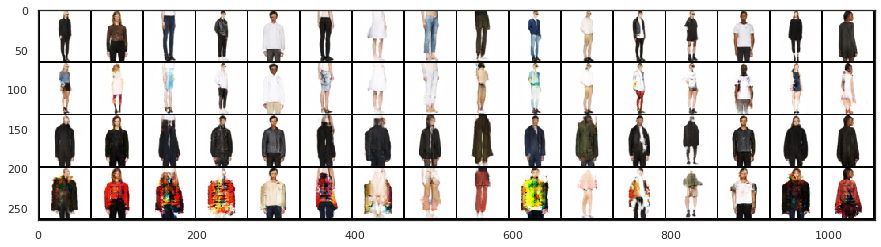

In [495]:
grid = torchvision.utils.make_grid(image_combo, nrow=16)
torchvision.utils.save_image(grid, 'colors.png')
plt.figure(figsize = (15, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [406]:
torch.cat([images_orig, images_white_07]).shape

torch.Size([32, 3, 64, 64])

In [389]:
num_images = 64
# 
noise_p, images, _, _ = gen_images(fashion_noise, model=fashion_model_fn, disc=None, classifier=None, perturb=perturb)
# change range to [0, 1] and set channels to RGB
images = images.permute(0, 2, 3, 1)*0.5+0.5

class_loss = red_loss(images)
print(class_loss)

whiteness_loss = white_loss(images)
print(whiteness_loss)

perturb_loss_fn = nn.MSELoss()
perturb_loss = perturb_loss_fn(noise_p, fashion_noise)
print(perturb_loss)

tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.3841e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward>)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [395]:
# colors = get_fashion_colors(images)
# colors_norm = colors/colors.mean(-1, keepdim=True)
# # colors_norm[:,0]
# colors.mean(-1)

In [501]:
num_images = 64
fashion_noise_64, _ = fashion_model.buildNoiseData(64)

noise_p, images, _, _ = gen_images(fashion_noise_64, model=fashion_model_fn, disc=None, classifier=None, perturb=None)
images = images.detach()*0.5+0.5
grid = torchvision.utils.make_grid(images, nrow=8)
torchvision.utils.save_image(grid, 'colors_regular.png')

noise_p, images, _, _ = gen_images(fashion_noise_64, model=fashion_model_fn, disc=None, classifier=None, perturb=perturb_white_09)
images = images.detach()*0.5+0.5
grid = torchvision.utils.make_grid(images, nrow=8)
torchvision.utils.save_image(grid, 'colors_white.png')

noise_p, images, _, _ = gen_images(fashion_noise_64, model=fashion_model_fn, disc=None, classifier=None, perturb=perturb_black_08)
images = images.detach()*0.5+0.5
grid = torchvision.utils.make_grid(images, nrow=8)
torchvision.utils.save_image(grid, 'colors_black.png')

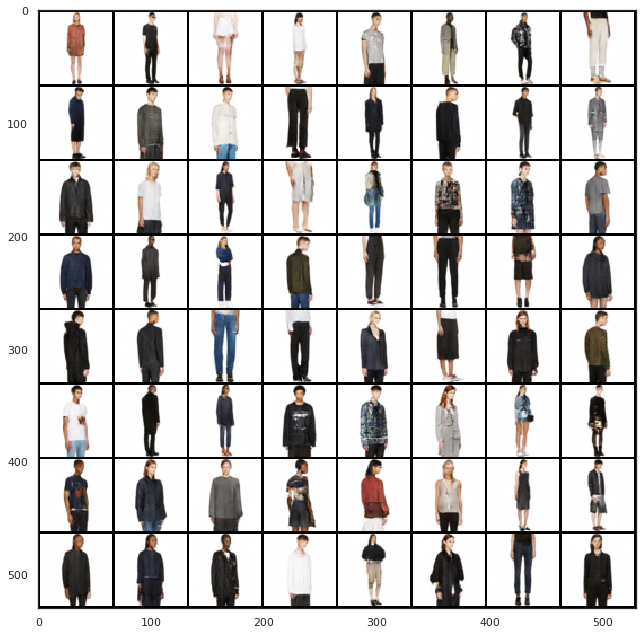

In [381]:
plt.imshow(make_grid(images.detach()))

In [246]:
# gen_images(noise, model=fashion_model, disc=None, perturb=perturb)

In [392]:
def make_grid(images, nrow=8):
    return torchvision.utils.make_grid(images.permute(0, 3, 1, 2), nrow=nrow).permute(1, 2, 0).cpu().numpy()

# plt.imshow(make_grid(generated_images))

#### Feature Extractor

In [211]:
class FeatureExtractor:
    def __init__(self):
        feat_extractor = LeNet5().eval()
        feat_extractor.load_state_dict(torch.load('../gan-vae-pretrained-pytorch/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth'))
        if torch.cuda.is_available():
            feat_extractor = feat_extractor.cuda()
        feat_extractor.eval()
        
        self.feat_extractor = feat_extractor
        self.fc = []
        
        feat_extractor.fc.f6.register_forward_hook(self._hook)
        
    def _hook(self, module, input, output):
        self.fc.append(output)
        
    def get_feats(self, images):
        ims = images.cuda()
        if images.shape[-1] == 28:
            ims = nn.functional.interpolate(ims, size=32).cuda()
        
        self.fc = []
        with torch.no_grad():
            self.feat_extractor(ims)
            
        return self.fc[0]
    

In [212]:
feature_extractor = FeatureExtractor()

#### Perturbation network

In [238]:
def get_perturb_network(latent_size=100, num_classes=0, init_identity=True):
    model = nn.Sequential(
        nn.Linear(latent_size+num_classes, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size*2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(latent_size*2, latent_size)
    ).cuda()

    if init_identity:
        # Initialize to identify weight matrix (as if nothing is happening)
        with torch.no_grad():
            for layer in model:
                if type(layer) == nn.Linear:
                    layer.weight = nn.Parameter(torch.eye(latent_size).cuda())
                    layer.bias = nn.Parameter(torch.zeros(latent_size).cuda())
                
    return model

#### Visualization

In [239]:
def umap_plot_images(embs, labels, images, xlim=None, ylim=None, cmap='bwr', show_legend=False):
    fig = plt.figure(figsize=(38,19), dpi=32, constrained_layout=False)

    grid_size=5

    # fig.tight_layout()
    gs = fig.add_gridspec(grid_size, grid_size*2, wspace=0, hspace=0)
    umap_ax = fig.add_subplot(gs[:, :grid_size])
    im_axes = []
    for i in range(grid_size):
        for j in range(grid_size):
            im_axes.append(fig.add_subplot(gs[i, j+grid_size]))
            im_axes[-1].set_axis_off()
    #         im_axes[-1].set(xticks=[], yticks=[])

    for i in range(grid_size**2):
        im_axes[i].imshow(images[i][0], aspect='auto', cmap='gray')

    scatter = umap_ax.scatter(embs[:,0], embs[:,1], s = 1, c = labels, cmap=cmap)
    if show_legend:
        # produce a legend with the unique colors from the scatter
        legend1 = umap_ax.legend(*scatter.legend_elements(),
                            title="", fontsize=25, markerscale=4)
        umap_ax.add_artist(legend1)
    umap_ax.get_xaxis().set_ticks([])
    umap_ax.get_yaxis().set_ticks([])
    umap_ax.set_axis_off()
    if xlim is not None and ylim is not None:
        umap_ax.set_xlim(xlim)
        umap_ax.set_ylim(ylim)
    
    return fig

def plot_two_types(emb1, emb2, images):
    all_embs_labels = np.concatenate((np.zeros(emb1.shape[0]), np.ones(emb2.shape[0])))
    all_embs = np.concatenate((emb1, emb2))
    xlim = [min(emb1[:,0])*1.1, max(emb1[:,0])*1.1]
    ylim = [min(emb1[:,1])*1.1, max(emb1[:,1])*1.1]
    return umap_plot_images(all_embs, all_embs_labels, images, xlim=xlim, ylim=ylim) #cmap='Spectral', show_legend=True)

#### Loss

In [594]:

batch_size = 2048
latent_size = 100

def show_images(ims):
    ims = ims.cpu().detach().numpy()[:25]
    ims = ims.reshape(ims.shape[0], ims.shape[-1], ims.shape[-1])
    R, C = 5, 5
    for i in range(ims.shape[0]):
        plt.subplot(R, C, i + 1)
        plt.imshow(ims[i], cmap='gray')
    plt.show()


def gen_noise(bs, dim=latent_size, class_tensor=None, num_classes=None):
    return torch.randn(bs, dim).cuda()

def noise_with_class(noise, class_tensor, num_classes):
    assert num_classes > max(class_tensor)
    noise_extra = torch.zeros(len(noise), num_classes).cuda()
    noise_extra[torch.arange(len(noise)), class_tensor] = 1
#     noise[:,0:num_classes] = 0
#     noise[torch.arange(len(noise)), class_tensor] = 1
    noise = torch.cat((noise, noise_extra), dim=1)
    return noise

In [241]:
noise = gen_noise(2, dim=5)
print(noise)
noise = noise_with_class(noise, np.asarray([3, 2]), 4)
print(noise)

tensor([[ 1.4585,  0.6816,  0.3486,  0.7520,  1.0862],
        [-0.5313,  0.4253,  0.5841, -0.4780, -1.3481]], device='cuda:0')
tensor([[ 1.4585,  0.6816,  0.3486,  0.7520,  1.0862,  0.0000,  0.0000,  0.0000,
          1.0000],
        [-0.5313,  0.4253,  0.5841, -0.4780, -1.3481,  0.0000,  0.0000,  1.0000,
          0.0000]], device='cuda:0')


In [551]:
def fairness_loss(pred, target, eps=1e-9):
    '''
    Computes KL divergence loss w.r.t. a target distribution
    
    Arguments:
        pred: (batch size, # classes)
        target: (# classes)
    '''
    batch_pred = pred.mean(0)
    return nn.KLDivLoss()((batch_pred+eps).log(), target)


In [255]:
def gen_images(noise, model=G, disc=D, classifier=classifier, perturb=None, num_classes=0):
    if perturb is not None:
        perturbation = perturb(noise)
        if num_classes > 0:
            noise_p = noise[:,:-num_classes] + perturbation
        else:
            noise_p = noise + perturbation
    else:
        noise_p = noise
    noise_p_lg = noise_p.unsqueeze(-1).unsqueeze(-1)

    images = model(noise_p_lg)
    
    preds = None
    if classifier is not None:
        images_interp = nn.functional.interpolate(images, size=32)
        preds = torch.exp(classifier(images_interp))
        
    disc_score = None
    if disc is not None:
        disc_score = disc(images)
        
    return noise_p, images, preds, disc_score

In [568]:
def train(perturb, class_weight=1, perturb_weight=1, disc_weight=1, iters=300, num_classes=10, target=None,
          save_dir=None, feature_extractor=None, mapping=None, real_embeds=None, conditional=False):
    
    if not (save_dir is None and mapping is None and real_embeds is None and feature_extractor is None):
        if not (save_dir is not None and mapping is not None and real_embeds is not None and feature_extractor is not None):
            print("dawg give it to me straight")
            return
    
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    optimizer = torch.optim.Adam(perturb.parameters())
    
    class_loss_fn = fairness_loss #nn.CrossEntropyLoss()
    perturb_loss_fn = nn.MSELoss()
    disc_loss_fn = nn.BCELoss()
    
    # noise for visualiztion
    vis_noise = gen_noise(25)

    losses = []
    for i in range(iters):

        # Train one iteration
        optimizer.zero_grad()
        
        
        noise = gen_noise(batch_size)
        
        if conditional:
            target = torch.randint(0, 9, (batch_size,)).cuda()
            noise = noise_with_class(noise, target, 10)
        else:
#             target = torch.ones(batch_size).long().cuda()

            # if no target is given, default to uniform distribution to encourage fairness
            if target is None:
                target = torch.ones(num_classes).cuda()/num_classes
            

        if conditional:
            noise_p, images, preds, disc_score = gen_images(noise, perturb=perturb, num_classes=10)
        else:
            noise_p, images, preds, disc_score = gen_images(noise, perturb=perturb)
        
        disc_target = torch.ones(batch_size).cuda() # 1 = real
         

        class_loss = class_loss_fn(preds, target)
        perturb_loss = perturb_loss_fn(noise_p, noise[:,:latent_size])
        disc_loss = disc_loss_fn(disc_score, disc_target)
        
        loss = class_weight * class_loss + perturb_weight * perturb_loss + disc_weight * disc_loss

        loss.backward()
        optimizer.step()
        
        # Visualization
        
        if save_dir is not None and i % 3 == 0:
            with torch.no_grad():
                
                _, images, _, _ = gen_images(gen_noise(3072), perturb)
                image_feats = feature_extractor.get_feats(images).cpu().numpy()
                new_embeds = mapping.transform(image_feats)
                
                _, images, _, _ = gen_images(vis_noise, perturb)
                fig = plot_two_types(real_embeds, new_embeds, images.detach().cpu().numpy())
                
                filename = os.path.join(save_dir, 'frame'+str(i)+'.png')
                fig.savefig(filename, dpi=72)
                plt.close(fig)

        losses.append(loss.item())
        if i % 50 == 0:
            print('Iter', i, '-- Loss', loss.item())
            
    return losses


Iter 0 -- Loss 0.004495188128203154
Iter 50 -- Loss 0.0018330310704186559
Iter 100 -- Loss 0.0019771012011915445
Iter 150 -- Loss 0.0014554521767422557
Iter 200 -- Loss 0.0031354064121842384
Iter 250 -- Loss 0.0008687059162184596


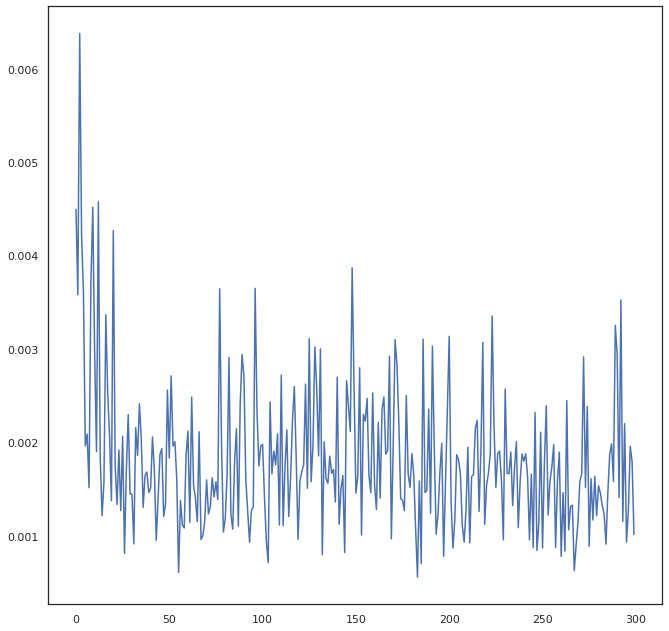

In [561]:
perturb = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, iters=300)
plt.plot(losses)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iter 0 -- Loss 0.0042376345954835415
Iter 50 -- Loss 0.0011039432138204575
Iter 100 -- Loss 0.0009416182292625308
Iter 150 -- Loss 0.000740843010134995
Iter 200 -- Loss 0.0008340934291481972
Iter 250 -- Loss 0.001144298235885799


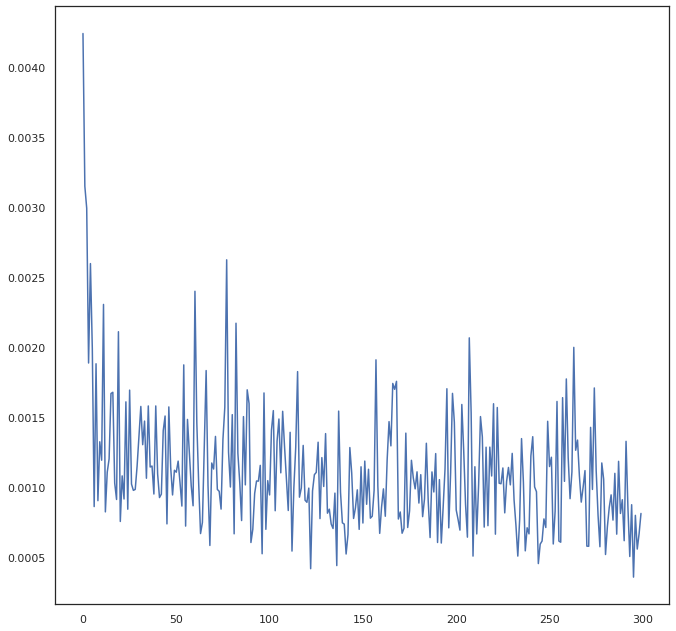

In [569]:
perturb = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, iters=300)
plt.plot(losses)

Iter 0 -- Loss 0.22557765245437622
Iter 50 -- Loss 0.04861406236886978
Iter 100 -- Loss 0.042658038437366486
Iter 150 -- Loss 0.03886537626385689
Iter 200 -- Loss 0.03371358662843704
Iter 250 -- Loss 0.03093087486922741
Iter 300 -- Loss 0.030308041721582413
Iter 350 -- Loss 0.028783489018678665
Iter 400 -- Loss 0.026548853144049644
Iter 450 -- Loss 0.027239929884672165


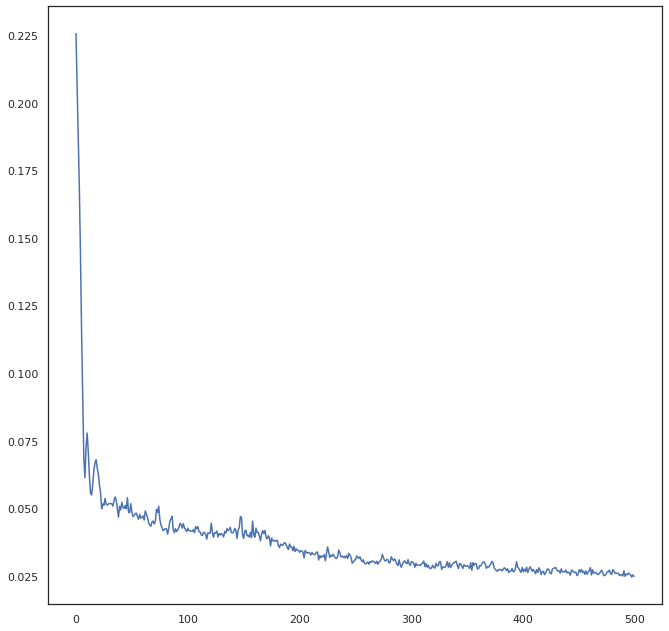

In [599]:
batch_size = 2048
perturb_one = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
target = torch.Tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).float().cuda()
losses = train(perturb_one, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)
plt.plot(losses)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iter 0 -- Loss 0.01648501679301262
Iter 50 -- Loss 0.00609955657273531
Iter 100 -- Loss 0.004417242482304573
Iter 150 -- Loss 0.005218928679823875
Iter 200 -- Loss 0.0052962228655815125
Iter 250 -- Loss 0.004213772714138031
Iter 300 -- Loss 0.004288764670491219
Iter 350 -- Loss 0.004873016849160194
Iter 400 -- Loss 0.004532096907496452
Iter 450 -- Loss 0.004444507881999016


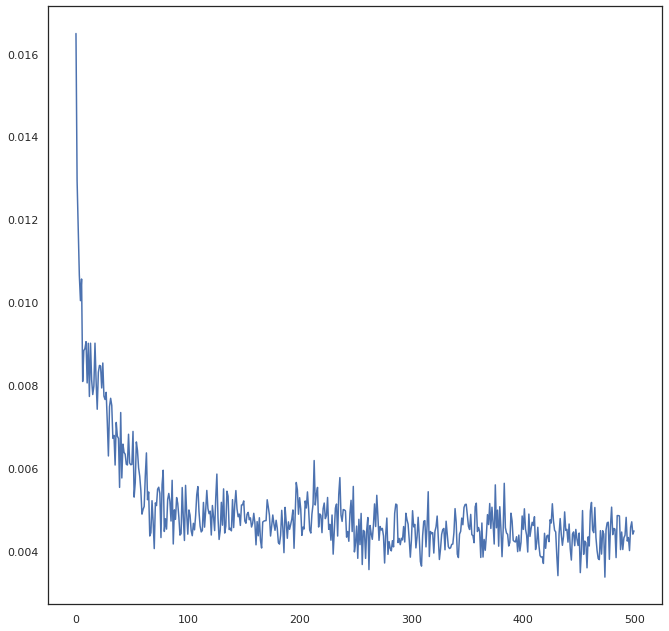

In [600]:
perturb_nothree = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
target = torch.Tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1]).float().cuda()
target /= target.sum()
losses = train(perturb_nothree, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)
plt.plot(losses)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iter 0 -- Loss 0.0801956057548523
Iter 50 -- Loss 0.03073296695947647
Iter 100 -- Loss 0.025839194655418396
Iter 150 -- Loss 0.02432052046060562
Iter 200 -- Loss 0.021283790469169617
Iter 250 -- Loss 0.019364185631275177
Iter 300 -- Loss 0.019944440573453903
Iter 350 -- Loss 0.019038602709770203
Iter 400 -- Loss 0.019158031791448593
Iter 450 -- Loss 0.018116557970643044


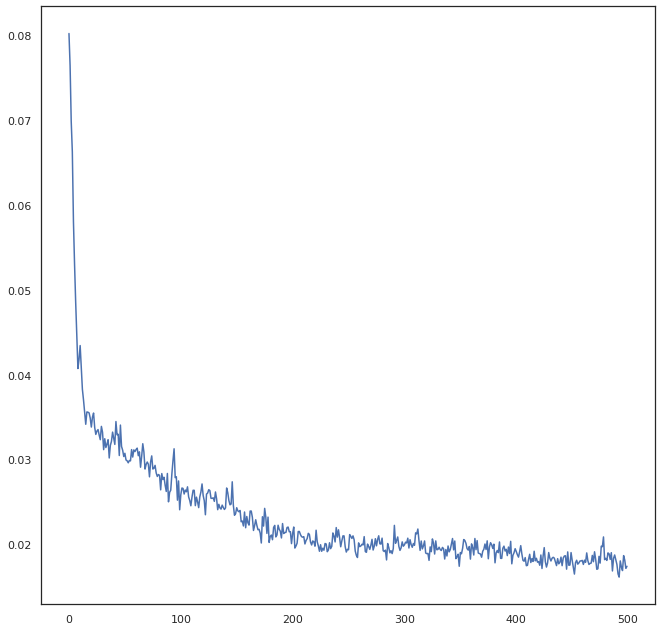

In [602]:
perturb_mixed = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
target = torch.Tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).float().cuda()
target /= target.sum()
losses = train(perturb_mixed, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)
plt.plot(losses)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iter 0 -- Loss 0.23329958319664001
Iter 50 -- Loss 0.05164642259478569
Iter 100 -- Loss 0.03978903219103813
Iter 150 -- Loss 0.038833294063806534
Iter 200 -- Loss 0.03948642313480377
Iter 250 -- Loss 0.031991612166166306
Iter 300 -- Loss 0.02908257767558098
Iter 350 -- Loss 0.02942642569541931
Iter 400 -- Loss 0.029130790382623672
Iter 450 -- Loss 0.025709493085741997
Iter 500 -- Loss 0.027814220637083054
Iter 550 -- Loss 0.02568933181464672
Iter 600 -- Loss 0.024377718567848206
Iter 650 -- Loss 0.024666132405400276
Iter 700 -- Loss 0.02559719979763031
Iter 750 -- Loss 0.024262044578790665
Iter 800 -- Loss 0.02448118105530739
Iter 850 -- Loss 0.02267487905919552
Iter 900 -- Loss 0.02340078353881836
Iter 950 -- Loss 0.022087523713707924


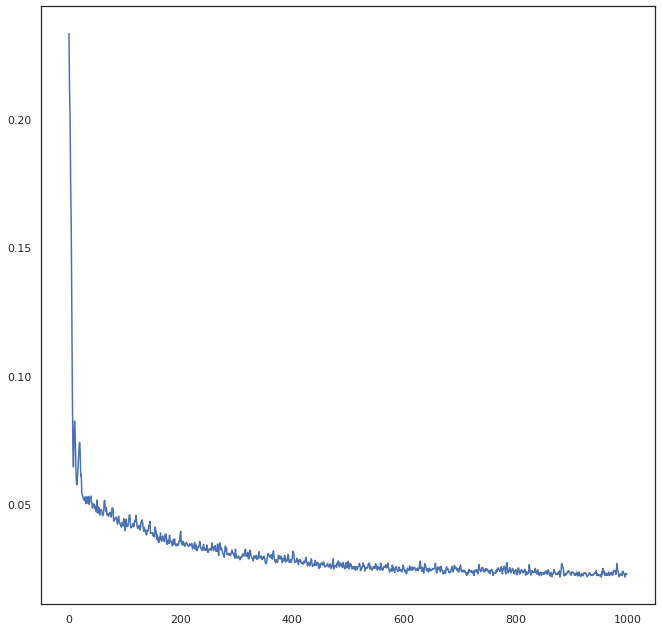

In [601]:
batch_size = 2048
perturb_one_1k = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
target = torch.Tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).float().cuda()
losses = train(perturb_one_1k, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=1000, target=target)
plt.plot(losses)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iter 0 -- Loss 0.23811450600624084
Iter 50 -- Loss 0.06450187414884567
Iter 100 -- Loss 0.045924507081508636
Iter 150 -- Loss 0.05228502303361893
Iter 200 -- Loss 0.04627883434295654
Iter 250 -- Loss 0.052634503692388535
Iter 300 -- Loss 0.05025000497698784
Iter 350 -- Loss 0.04952992498874664
Iter 400 -- Loss 0.06501394510269165
Iter 450 -- Loss 0.05617097020149231
Iter 0 -- Loss 0.2482176274061203
Iter 50 -- Loss 0.058435358107089996
Iter 100 -- Loss 0.04688660800457001
Iter 150 -- Loss 0.04980102926492691
Iter 200 -- Loss 0.046330928802490234
Iter 250 -- Loss 0.04746640473604202
Iter 300 -- Loss 0.052705563604831696
Iter 350 -- Loss 0.06261786818504333
Iter 400 -- Loss 0.054613277316093445
Iter 450 -- Loss 0.046522356569767
Iter 0 -- Loss 0.23457539081573486
Iter 50 -- Loss 0.05051404982805252
Iter 100 -- Loss 0.04524626210331917
Iter 150 -- Loss 0.03929830342531204
Iter 200 -- Loss 0.03464549407362938
Iter 250 -- Loss 0.031734175980091095
Iter 300 -- Loss 0.028510404750704765
Iter 

NameError: name 'losses_b256' is not defined

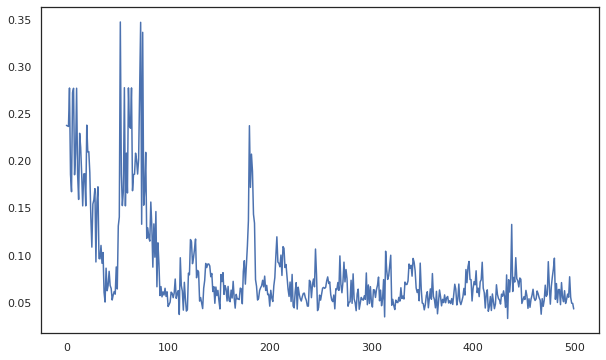

In [603]:
target = torch.Tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).float().cuda()
batch_size = 32
perturb_one_b32 = get_perturb_network(num_classes=0, init_identity=False)
losses_b32 = train(perturb_one_b32, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)

batch_size = 256
perturb_one_b256 = get_perturb_network(num_classes=0, init_identity=False)
losses_256 = train(perturb_one_b256, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)

batch_size = 2048
perturb_one_b2048 = get_perturb_network(num_classes=0, init_identity=False)
losses_b2048 = train(perturb_one_b2048, class_weight=1, perturb_weight=0.5, disc_weight=0, iters=500, target=target)

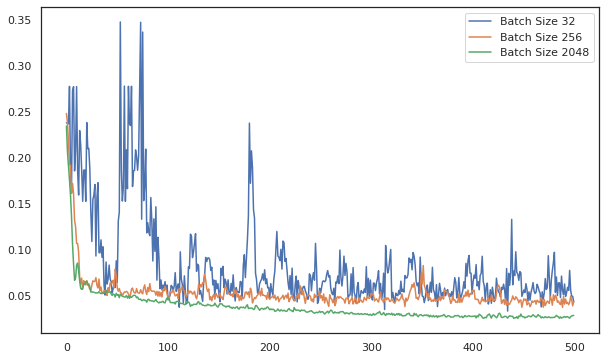

In [605]:
plt.figure(figsize=(10,6))
plt.plot(losses_b32, label = "Batch Size 32")
plt.plot(losses_256, label = "Batch Size 256")
plt.plot(losses_b2048, label = "Batch Size 2048")
plt.legend()
plt.show()

#### class=1, perturb=0, disc=0

In [238]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=0, disc_weight=0)

Iter 0 -- Loss 2.339259147644043
Iter 50 -- Loss 1.8719520568847656
Iter 100 -- Loss 1.7921626567840576
Iter 150 -- Loss 1.7645868062973022
Iter 200 -- Loss 1.780320644378662
Iter 250 -- Loss 1.737691879272461


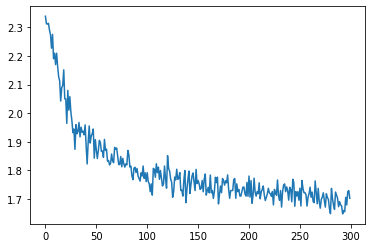

In [239]:
plt.plot(losses)

In [240]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)

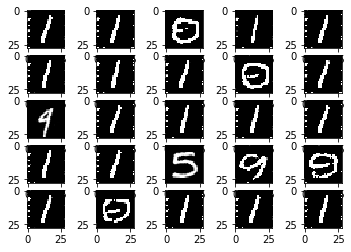

In [241]:
show_images(images)

In [242]:
preds.argmax(-1)

tensor([1, 1, 5, 1, 1, 1, 1, 1, 0, 1, 9, 1, 1, 1, 1, 1, 1, 5, 9, 5, 1, 5, 1, 1,
        1], device='cuda:0')

#### class=1, perturb=1, disc=0

Iter 0 -- Loss 2.338912010192871
Iter 50 -- Loss 1.6242890357971191
Iter 100 -- Loss 1.6147704124450684
Iter 150 -- Loss 1.5900051593780518
Iter 200 -- Loss 1.5833103656768799
Iter 250 -- Loss 1.6781542301177979


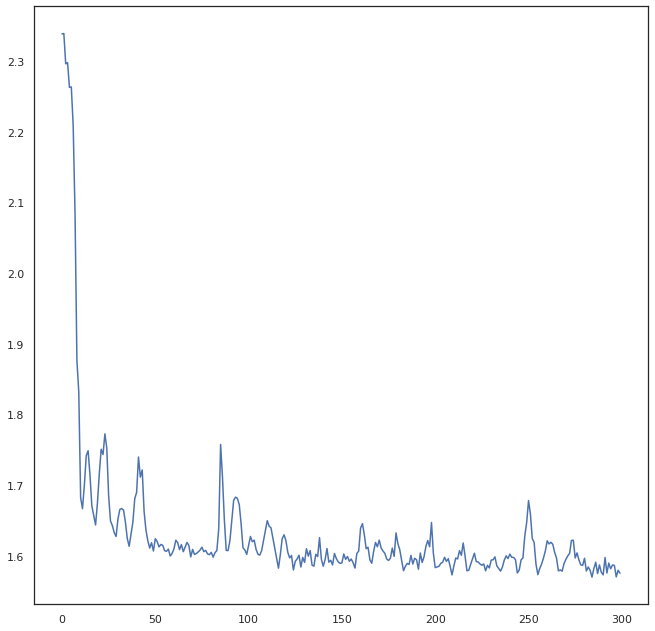

In [115]:
perturb = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, iters=300)
plt.plot(losses)

tensor([7, 1, 7, 7, 5, 3, 5, 7, 7, 2, 8, 3, 4, 4, 2, 1, 2, 3, 4, 1, 7, 8, 9, 7,
        6], device='cuda:0')
Mean Disc loss:  0.27611044049263


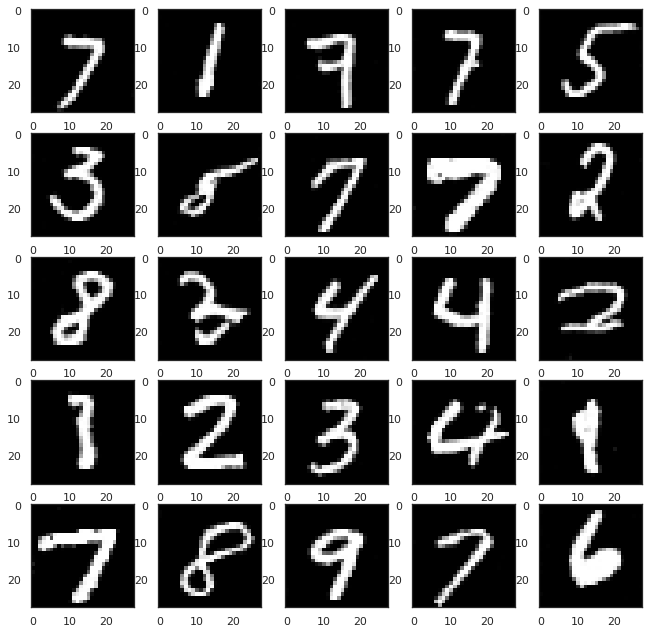

In [224]:
noise = gen_noise(25)
noise_p, images, preds, disc_score = gen_images(noise, None)

print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### 1,1,0.1

Iter 0 -- Loss 2.3486156463623047
Iter 50 -- Loss 2.3029696941375732
Iter 100 -- Loss 2.255484104156494
Iter 150 -- Loss 2.2418415546417236
Iter 200 -- Loss 2.2359049320220947
Iter 250 -- Loss 2.2235872745513916
Iter 300 -- Loss 2.2259161472320557
Iter 350 -- Loss 2.207495927810669
Iter 400 -- Loss 2.186492919921875
Iter 450 -- Loss 2.2290000915527344
Iter 500 -- Loss 2.1519899368286133
Iter 550 -- Loss 2.196277379989624
Iter 600 -- Loss 2.1220593452453613
Iter 650 -- Loss 2.1358203887939453
Iter 700 -- Loss 2.1055052280426025
Iter 750 -- Loss 2.102397918701172
Iter 800 -- Loss 2.1580159664154053
Iter 850 -- Loss 2.0909616947174072
Iter 900 -- Loss 2.1005120277404785
Iter 950 -- Loss 2.0682647228240967


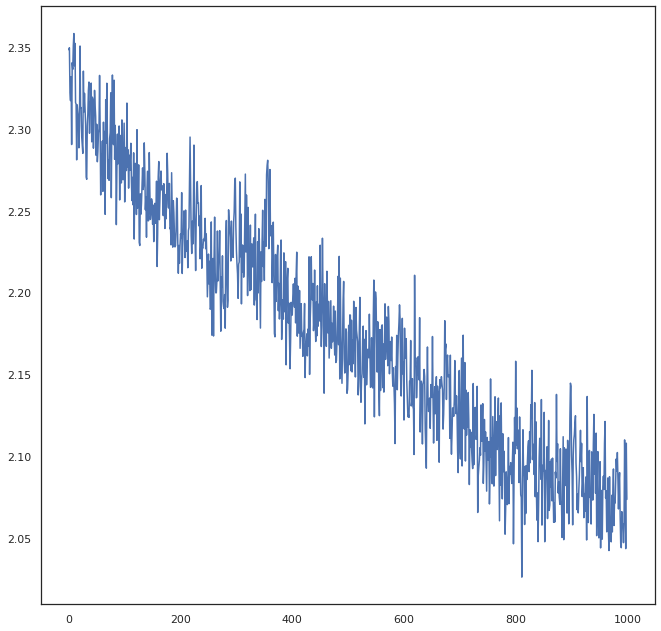

In [97]:
# Now, conditionally:
perturb_cond = get_perturb_network(num_classes=10, init_identity=False)
losses = train(perturb_cond, class_weight=1, perturb_weight=1, disc_weight=0.05, iters=1000, conditional=True)
plt.plot(losses)

tensor([7, 4, 2, 1, 5, 1, 2, 3, 0, 3, 4, 3, 1, 7, 0, 1, 4, 4, 3, 5, 4, 5, 0, 4,
        2], device='cuda:0')
tensor([7, 1, 2, 1, 5, 1, 2, 3, 0, 3, 4, 3, 1, 1, 0, 1, 4, 4, 8, 5, 8, 5, 0, 4,
        2], device='cuda:0')
Mean Disc loss:  0.3738105595111847


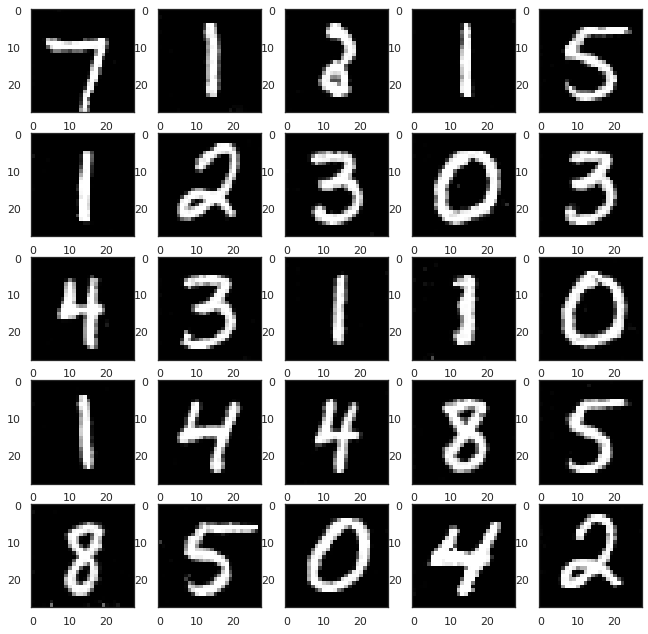

In [242]:
classes = torch.randint(0, 9, (25,)).cuda() #torch.ones(25).long().cuda()*2#
noise = gen_noise(25)
noise_p, images, preds, disc_score = gen_images(noise_with_class(noise, classes, 10), perturb, num_classes=10)
# noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(classes)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

tensor([1, 6, 2, 2, 0, 3, 2, 9, 3, 5, 5, 7, 2, 2, 7, 4, 7, 5, 8, 8, 3, 4, 7, 2,
        9], device='cuda:0')
Mean Disc loss:  0.15276014804840088


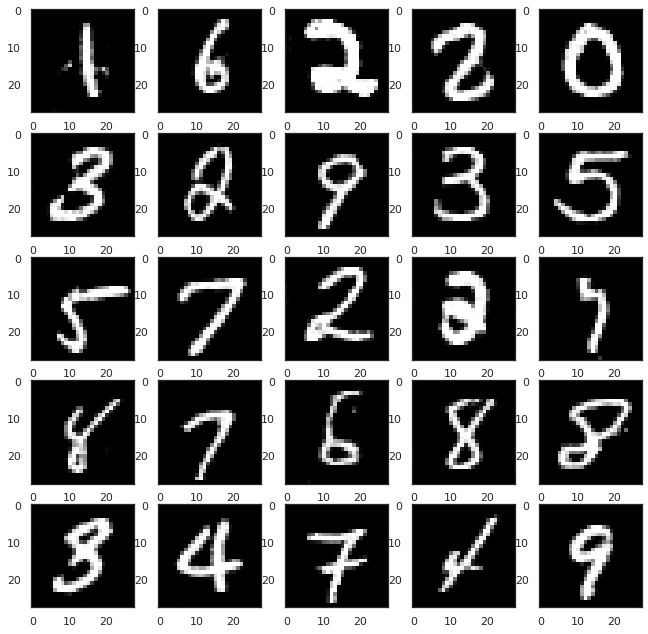

In [243]:
# Generate with same noise, but not conditinally
noise_p, images, preds, disc_score = gen_images(noise, None)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=10

Iter 0 -- Loss 22.689807891845703
Iter 50 -- Loss 22.109020233154297
Iter 100 -- Loss 20.55162811279297
Iter 150 -- Loss 18.349477767944336
Iter 200 -- Loss 16.001930236816406
Iter 250 -- Loss 14.418083190917969
Iter 300 -- Loss 13.935626983642578
Iter 350 -- Loss 13.079444885253906
Iter 400 -- Loss 11.146703720092773
Iter 450 -- Loss 9.864684104919434
Iter 500 -- Loss 8.256194114685059
Iter 550 -- Loss 5.993600845336914
Iter 600 -- Loss 5.265566825866699
Iter 650 -- Loss 4.917550086975098
Iter 700 -- Loss 4.23323917388916
Iter 750 -- Loss 4.299526214599609
Iter 800 -- Loss 4.154753684997559
Iter 850 -- Loss 3.745466709136963
Iter 900 -- Loss 3.459221839904785
Iter 950 -- Loss 3.376338243484497


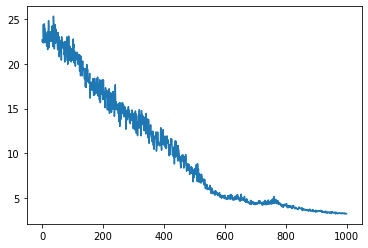

In [246]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=10, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.931740403175354


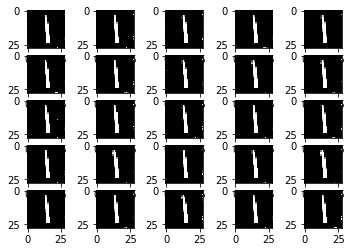

In [247]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=1

Iter 0 -- Loss 4.342452526092529
Iter 50 -- Loss 4.343758583068848
Iter 100 -- Loss 4.296798229217529
Iter 150 -- Loss 4.000028610229492
Iter 200 -- Loss 3.7808709144592285
Iter 250 -- Loss 3.7091588973999023
Iter 300 -- Loss 3.2532858848571777
Iter 350 -- Loss 2.9648799896240234
Iter 400 -- Loss 2.695672035217285
Iter 450 -- Loss 2.4445652961730957
Iter 500 -- Loss 2.3015124797821045
Iter 550 -- Loss 2.201127767562866
Iter 600 -- Loss 2.1183526515960693
Iter 650 -- Loss 2.0582480430603027
Iter 700 -- Loss 2.0080113410949707
Iter 750 -- Loss 1.9744704961776733
Iter 800 -- Loss 1.9462461471557617
Iter 850 -- Loss 1.9280515909194946
Iter 900 -- Loss 1.8829634189605713
Iter 950 -- Loss 1.7947810888290405


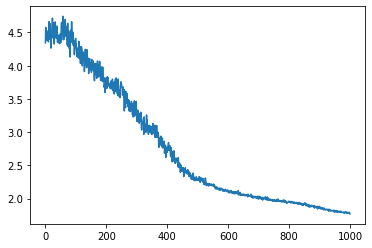

In [248]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=1, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.9085697531700134


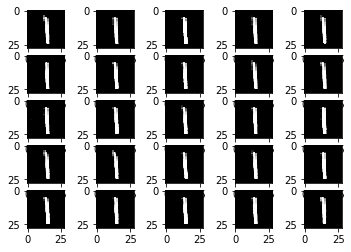

In [249]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

In [250]:
torch.softmax(preds, -1)[0].sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

#### class=1, perturb=1, disc=0.1

Iter 0 -- Loss 2.561955690383911
Iter 50 -- Loss 2.332526683807373
Iter 100 -- Loss 2.150678873062134
Iter 150 -- Loss 2.0226593017578125
Iter 200 -- Loss 1.829315423965454
Iter 250 -- Loss 1.7463833093643188
Iter 300 -- Loss 1.7073520421981812
Iter 350 -- Loss 1.651883602142334
Iter 400 -- Loss 1.6472777128219604
Iter 450 -- Loss 1.6412445306777954
Iter 500 -- Loss 1.64120352268219
Iter 550 -- Loss 1.6505237817764282
Iter 600 -- Loss 1.6399091482162476
Iter 650 -- Loss 1.6263082027435303
Iter 700 -- Loss 1.6240373849868774
Iter 750 -- Loss 1.622225046157837
Iter 800 -- Loss 1.6253957748413086
Iter 850 -- Loss 1.619353175163269
Iter 900 -- Loss 1.6032816171646118
Iter 950 -- Loss 1.6168516874313354


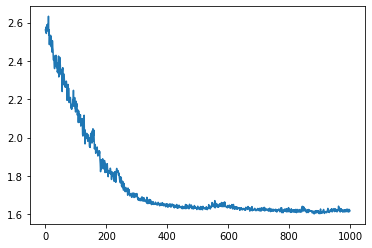

In [251]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.1, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.5940985083580017


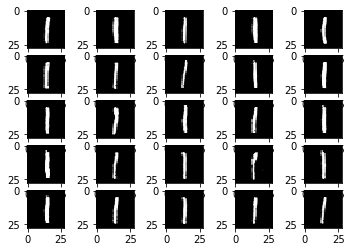

In [252]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=0.01

Iter 0 -- Loss 2.381848096847534
Iter 50 -- Loss 2.109687328338623
Iter 100 -- Loss 1.9615917205810547
Iter 150 -- Loss 1.9207170009613037
Iter 200 -- Loss 1.7051924467086792
Iter 250 -- Loss 1.6204783916473389
Iter 300 -- Loss 1.6165738105773926
Iter 350 -- Loss 1.5759223699569702
Iter 400 -- Loss 1.5696383714675903
Iter 450 -- Loss 1.5886493921279907
Iter 500 -- Loss 1.561998724937439
Iter 550 -- Loss 1.5467408895492554
Iter 600 -- Loss 1.5357848405838013
Iter 650 -- Loss 1.5517852306365967
Iter 700 -- Loss 1.5464978218078613
Iter 750 -- Loss 1.5344576835632324
Iter 800 -- Loss 1.5525546073913574
Iter 850 -- Loss 1.5935688018798828
Iter 900 -- Loss 1.5767287015914917
Iter 950 -- Loss 1.5787477493286133


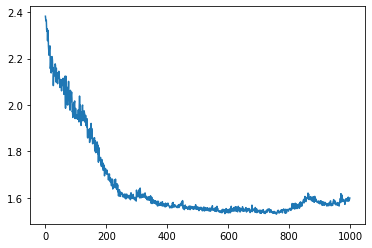

In [257]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.01, iters=1000)
plt.plot(losses)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.2925819456577301


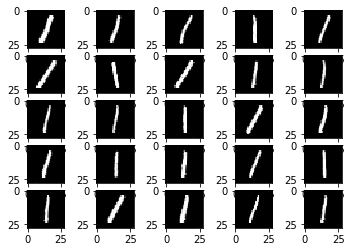

In [259]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### class=1, perturb=1, disc=0.05

Iter 0 -- Loss 2.453378677368164
Iter 50 -- Loss 2.22053599357605
Iter 100 -- Loss 2.0463058948516846
Iter 150 -- Loss 1.854372262954712
Iter 200 -- Loss 1.793121576309204
Iter 250 -- Loss 1.6907340288162231
Iter 300 -- Loss 1.6379029750823975
Iter 350 -- Loss 1.6432545185089111
Iter 400 -- Loss 1.619269609451294
Iter 450 -- Loss 1.612392783164978


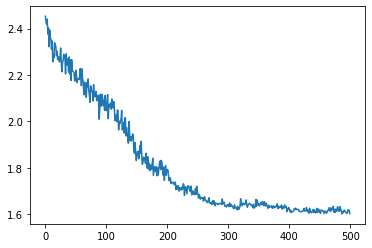

In [15]:
perturb = get_perturb_network()
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0.05, iters=500)
plt.plot(losses)

tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1], device='cuda:0')
Mean Disc loss:  0.3729730248451233


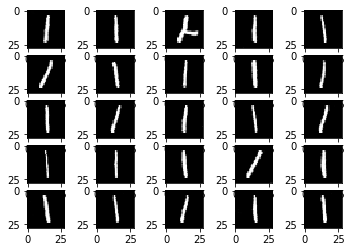

In [16]:
noise_p, images, preds, disc_score = gen_images(gen_noise(25), perturb)
print(preds.argmax(-1))
print("Mean Disc loss: ", D(images).mean().item())
show_images(images)

#### 1, 1, 0 with fairness target

In [550]:
perturb = get_perturb_network(num_classes=0, init_identity=False)
#losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, save_dir='josh1/', feature_extractor=feature_extractor, mapping=mapper, real_embeds=real_embs[:7500], iters=402)
losses = train(perturb, class_weight=1, perturb_weight=1, disc_weight=0, iters=300, num_classes=10, target=None)
plt.plot(losses)

RuntimeError: size mismatch, m1: [51200 x 1], m2: [100 x 200] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

# Josh

In [683]:
(ims, labs) = next(iter(data_loader))

In [21]:
# show_images(nn.functional.interpolate(ims, size=28))

In [684]:
real_feats = feature_extractor.get_feats(ims).cpu().numpy()

In [685]:
mapper = umap.UMAP().fit(real_feats)

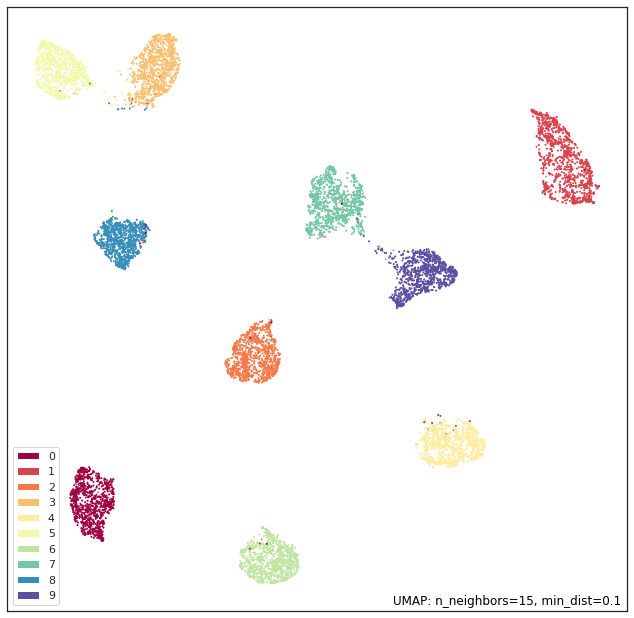

In [686]:
umap.plot.points(mapper, labels=labs)

In [687]:
real_embs = mapper.transform(real_feats)

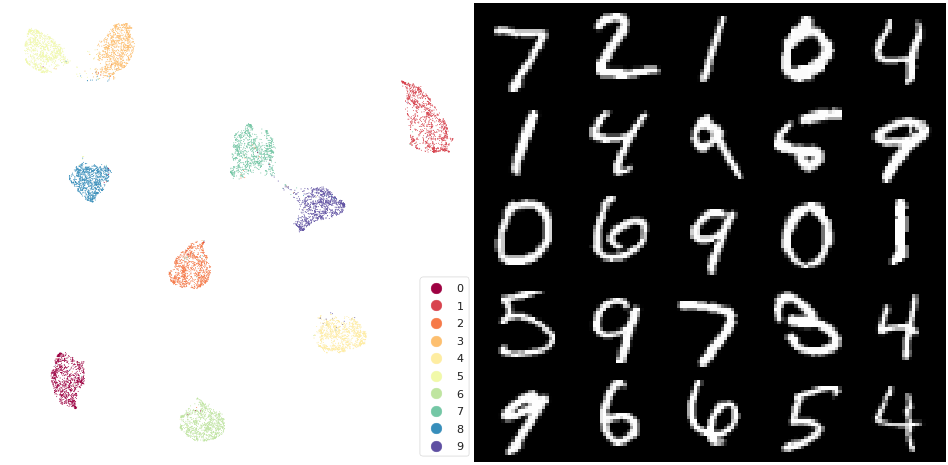

In [688]:
plot = umap_plot_images(real_embs, labs, ims.cpu(), cmap='Spectral', show_legend=True)

In [689]:
# generate samples from gan
sample_size = 1024
images_fake = []
with torch.no_grad():
    for i in range(10):
        _, images, _, _ = gen_images(gen_noise(sample_size))
        images_fake.append(images)
images_fake = torch.cat(images_fake)

In [690]:
images_fake.shape

torch.Size([10240, 1, 28, 28])

In [701]:
fake_feats = feature_extractor.get_feats(images_fake).cpu().numpy()
fake_embeds = mapper.transform(fake_feats)
# fake_embeds.shape

In [692]:
classes = classifier(nn.functional.interpolate(images_fake, size=32))
class_nums = classes.argmax(-1)

(array([ 986., 1047., 1204., 1146.,  878., 1116.,  957., 1101.,  678.,
        1127.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

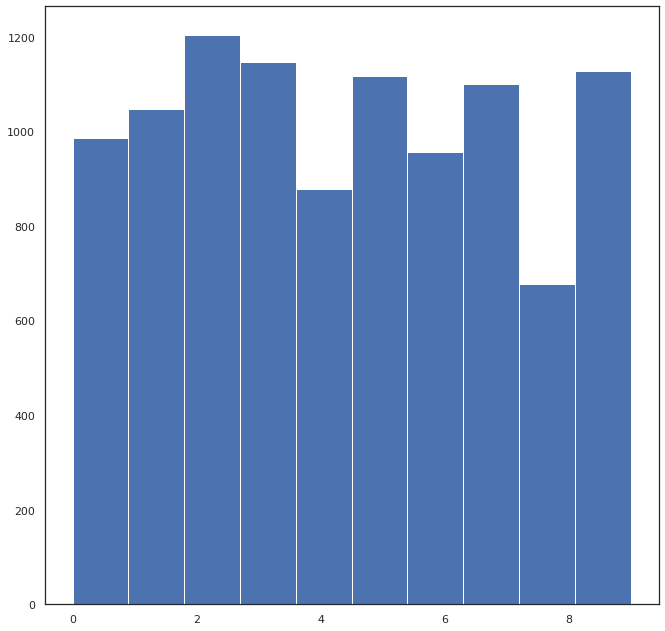

In [693]:
plt.hist(class_nums.detach().cpu().numpy())

In [706]:
# generate samples from perturbed gan
sample_size = 3072
noise = gen_noise(sample_size)
_, images_perturbed, _, _ = gen_images(noise, perturb=perturb_one_1k)

# noise = gen_noise(sample_size)
# classes = torch.randint(0, 9, (sample_size,)).cuda()
# noise = noise_with_class(noise, classes, 10)
# _, images_perturbed, _, _ = gen_images(noise, perturb_cond, num_classes=10)
# show_images(images)

RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 14.76 GiB total capacity; 13.35 GiB already allocated; 135.75 MiB free; 13.92 GiB reserved in total by PyTorch)

In [695]:
perturbed_feats = feature_extractor.get_feats(images_perturbed).cpu().numpy()
perturbed_embs = mapper.transform(perturbed_feats)

In [696]:
classes_p = classifier(nn.functional.interpolate(images_perturbed, size=32))
class_nums_p = classes_p.argmax(-1)

(array([   7., 2940.,   22.,   20.,   17.,   10.,    9.,   24.,    6.,
          17.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

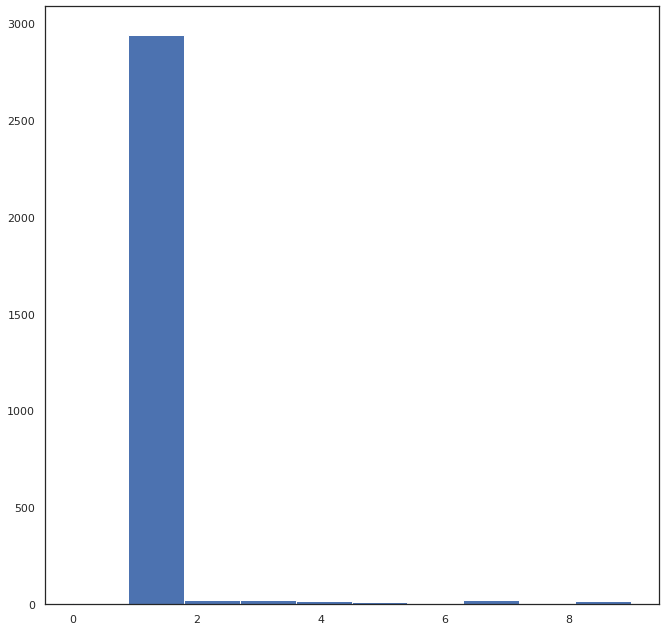

In [697]:
plt.hist(class_nums_p.detach().cpu().numpy())

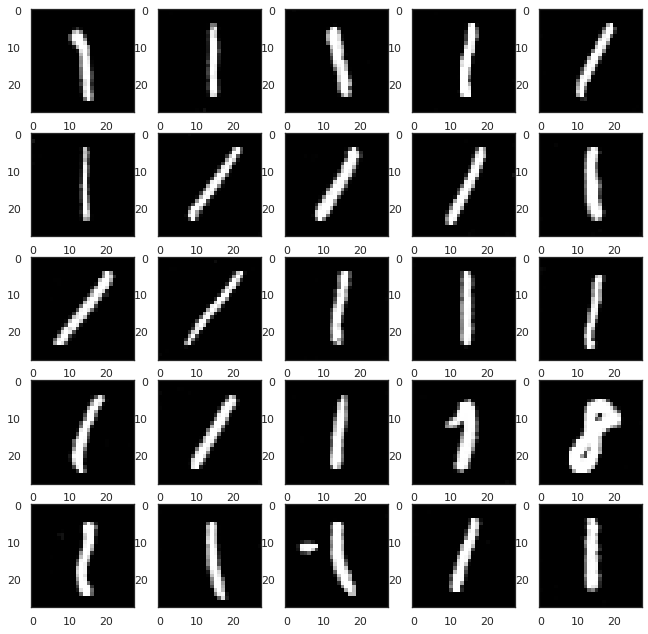

In [698]:
show_images(images_perturbed)

In [650]:
def save_images(images_perturbed, folder='no_three'):
    images_cloned = images_perturbed#[:25]
    images_cloned = torch.cat([images_cloned]*3, dim=1)
    for i in range(len(images_cloned)):
        torchvision.utils.save_image(images_cloned[i], 'images/'+folder+'/image'+str(i+1)+'.png')

(array([  11., 2836.,   43.,   18.,   14.,   14.,   18.,   20.,   16.,
          10.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

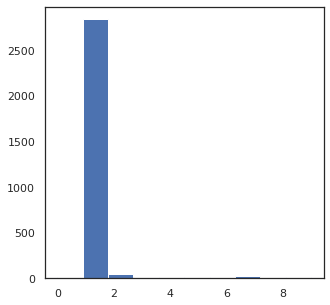

In [677]:
all_images = []
for i in range(3):
    sample_size = 1000
    noise = gen_noise(sample_size)
    _, images_perturbed, _, _ = gen_images(noise, perturb=model)
    all_images.append(images_perturbed)
    
images_perturbed = torch.cat(all_images)

classes_p = classifier(nn.functional.interpolate(images_perturbed, size=32))
class_nums_p = classes_p.argmax(-1)

plt.figure(figsize=(5, 5))
plt.hist(class_nums_p.detach().cpu().numpy())

In [667]:
perturb_one

Sequential(
  (0): Linear(in_features=100, out_features=200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=200, out_features=200, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=200, out_features=200, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=200, out_features=100, bias=True)
)

In [673]:
torch.save(perturb_one, 'models/one_test.pt')

In [674]:
model = torch.load('models/one_test.pt')
# model = get_perturb_network()
# model.load_state_dict(torch.load('models/one_test.pt'))

In [54]:
images_fake.shape

torch.Size([10240, 1, 28, 28])

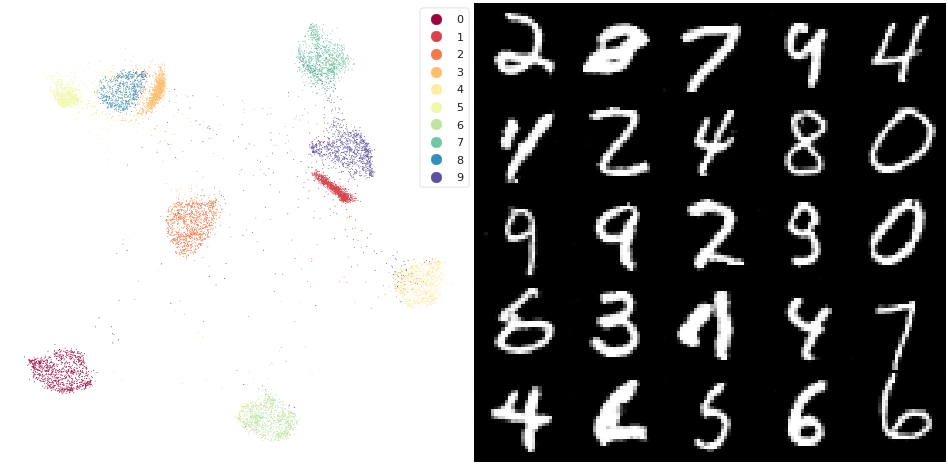

In [55]:
# plot GAN generated image distribution
fake_labels = classifier(nn.functional.interpolate(images_fake, size=32)).detach().cpu().numpy().argmax(-1)
plot = umap_plot_images(fake_embeds, fake_labels, images_fake[:25].detach().cpu().numpy(), cmap='Spectral', show_legend=True)

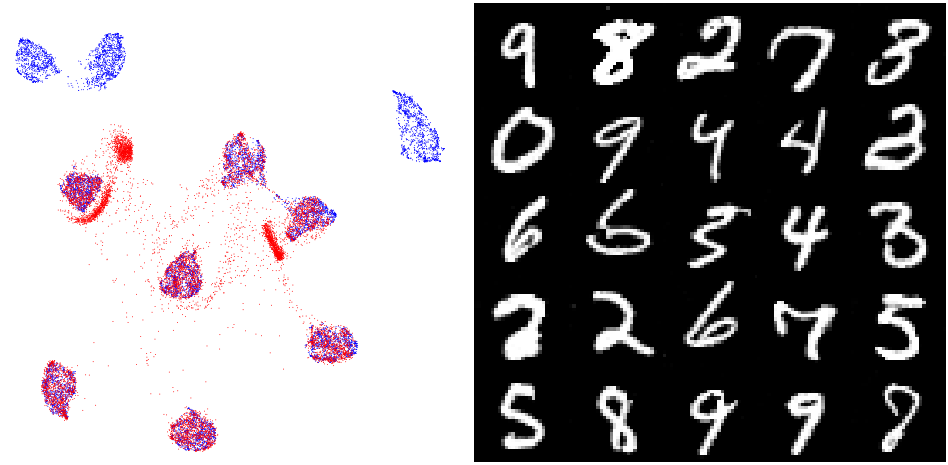

In [702]:
# plot real vs fake embedings
plot = plot_two_types(real_embs, fake_embeds, images_fake[:25].detach().cpu().numpy())

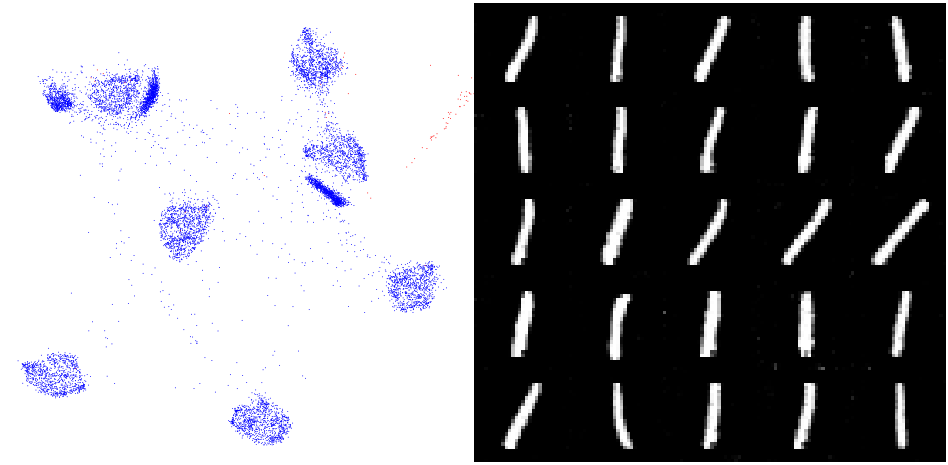

In [57]:
# plot GAN vs perturbed GAN
# plot = umap_plot_images(fake_embeds, fake_labels, fake_interp[:25].detach().cpu().numpy(),cmap='Spectral', show_legend=True)
plot = plot_two_types(fake_embeds, perturbed_embs, images_perturbed[:25].detach().cpu().numpy())

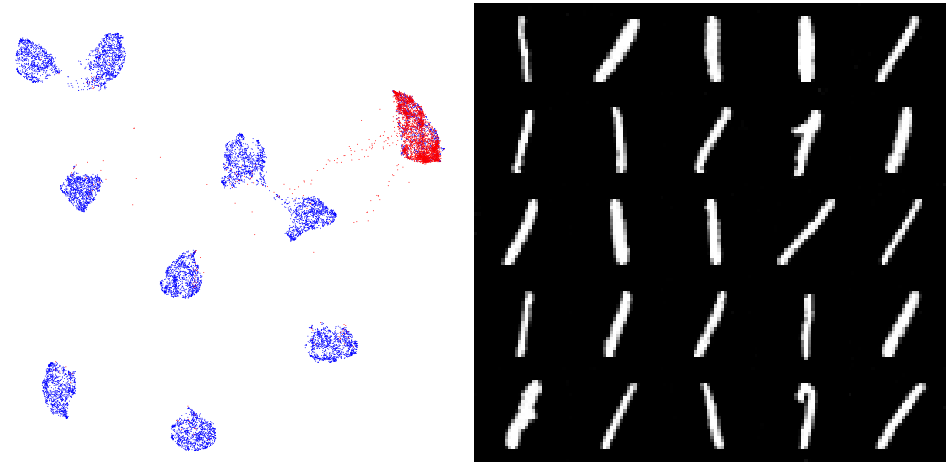

In [704]:
# plot real vs perturbed
# plot = umap_plot_images(fake_embeds, fake_labels, fake_interp[:25].detach().cpu().numpy(),cmap='Spectral', show_legend=True)
plot = plot_two_types(real_embs, perturbed_embs, images_perturbed[50:75].detach().cpu().numpy())

In [51]:
# plot.savefig('temp.png', dpi=72)

In [122]:
noise = gen_noise(32*128)
# classes = torch.ones(25).long().cuda()*2
# noise = noise_with_class(noise, classes, 10)
_, images_ones, _, _ = gen_images(noise, perturb)#, num_classes=10)


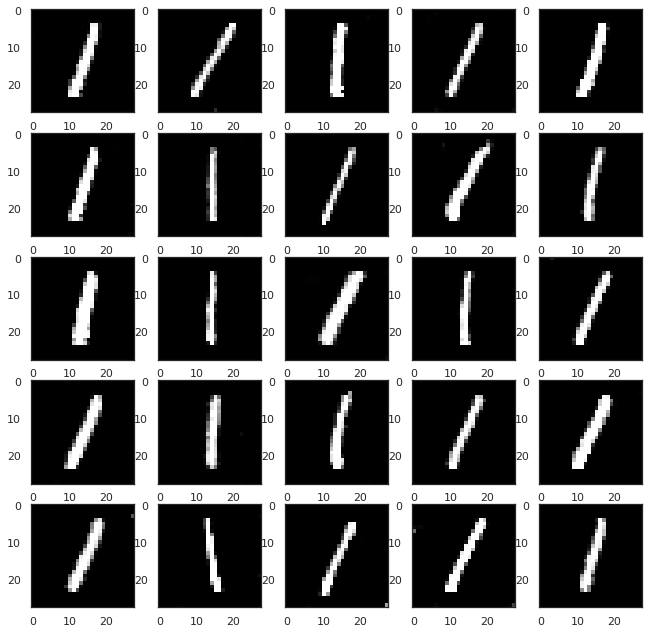

In [123]:
show_images(images_ones)

In [101]:
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

In [102]:
def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [126]:
inception_score(images_ones, cuda=True, batch_size=32, resize=True, splits=1)

KeyboardInterrupt: 